# Assignment 4
- 2017572003 Jaeyung Lee
- 2017572026 Juyeon Moon

In [35]:
import os
import matplotlib.pyplot as plt
import numpy as np
from detectors import *
from gazeplotter import *
from collections import defaultdict

### Preprocessing the Data format

In [36]:
def preprocess(raw):
    x = [] # x-coordinates
    y = [] # y-coordinates
    t = [] # timestamps
    p = [] # pupil data
    for i in np.arange(len(raw)):
        currentLine = raw[i].replace('\n','').replace('\r','').replace(',',' ').split()
        if (i==0):
            startTime = float(currentLine[0])/1000

        if float(currentLine[7])>0 and float(currentLine[20])>0:
            x.append(((float(currentLine[7])+float(currentLine[20]))/2)*1280)
        elif float(currentLine[7])>0:
            x.append(float(currentLine[7])*1280)
        elif float(currentLine[20])>0:
            x.append(float(currentLine[20])*1280)
        else:
            x.append(float(currentLine[7]))

        # join left eye and right eye data for y coordinates
        if float(currentLine[8])>0 and float(currentLine[21])>0:
            y.append(((float(currentLine[8])+float(currentLine[21]))/2)*1024)
        elif float(currentLine[8])>0:
            y.append(float(currentLine[8])*1024)
        elif float(currentLine[21])>0:
            y.append(float(currentLine[21])*1024)
        else:
            y.append(float(currentLine[8]))

        # join left and right pupil size
        if float(currentLine[12])>0 and float(currentLine[25])>0:
            p.append(((float(currentLine[12])+float(currentLine[25]))/2))
        elif float(currentLine[12])>0:
            p.append(float(currentLine[12]))
        elif float(currentLine[25])>0:
            p.append(float(currentLine[25]))
        else:
            p.append(float(currentLine[12]))
        t.append(float(currentLine[0])/1000-startTime)
    return x,y,t,p

### get pupil value function

In [37]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [38]:
def get_pupil(p):
    p = np.array(p)
    p[p<0] = np.nan
    nans, pi = nan_helper(p)
    p[nans] = np.interp(pi(nans), pi(~nans), p[~nans])
    
    return p

### make some use of gazeplotter

It looks like working well. Raw points and scanpath are gathered in letter side. So we used the default parameters.

D:\download\anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


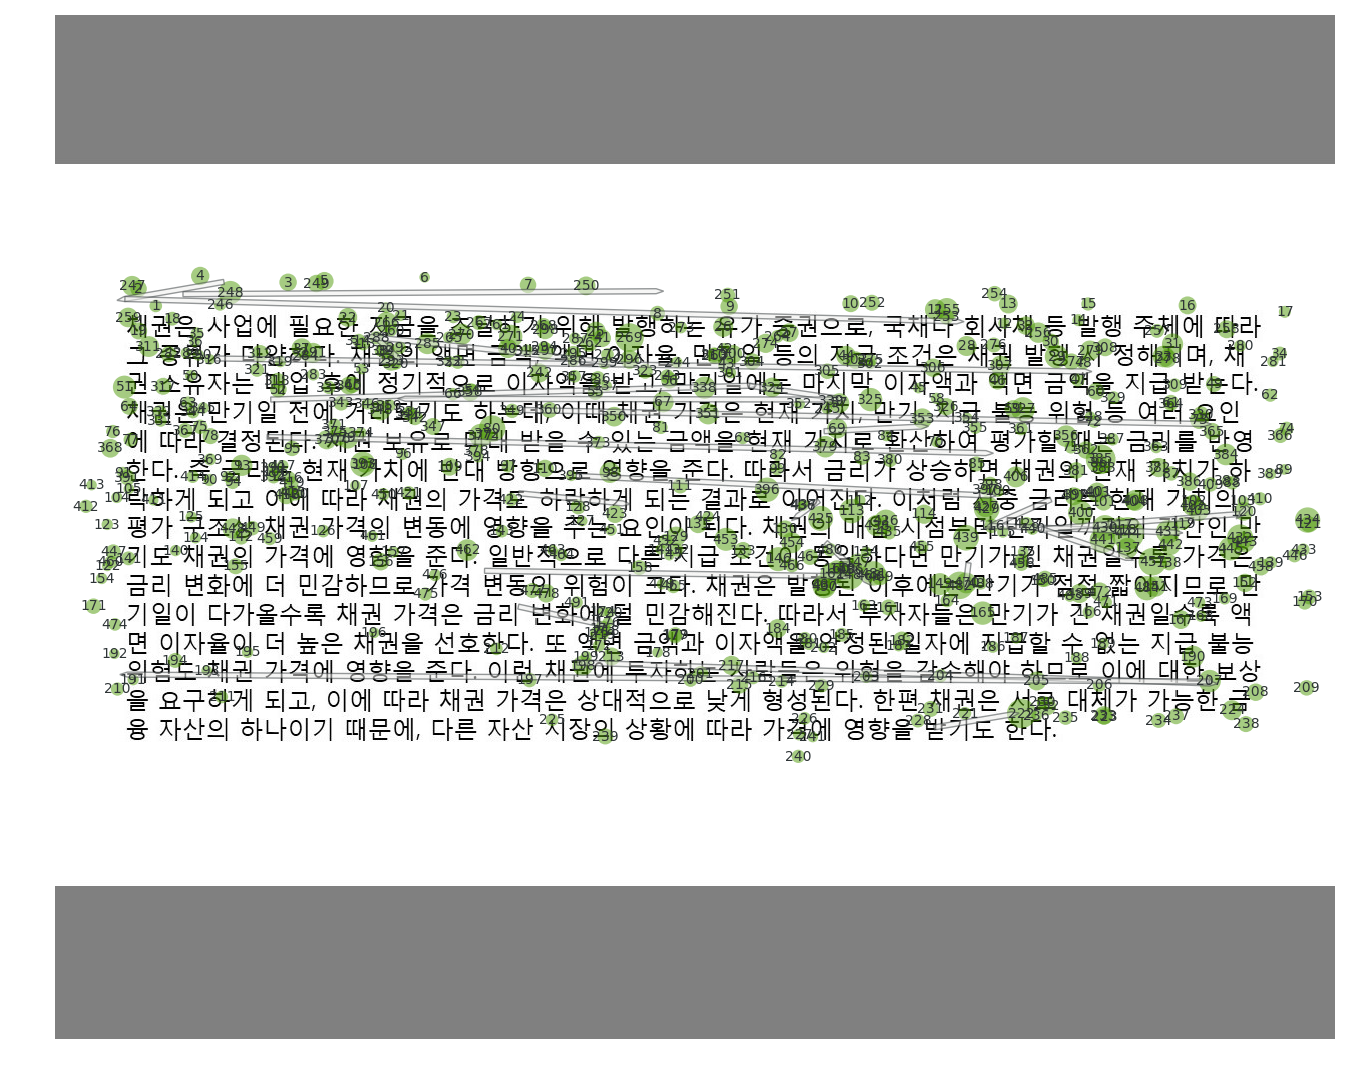

In [117]:
f = open('./data/noglass/participant002_slide001.txt', 'r')

raw = f.readlines()

x, y, t, p = preprocess(raw)

missings, Sblk, Eblk, Ablk = blink_detection(x,y,t, missing=-1.0)
Ssac, Esac = saccade_detection(x,y,t, missings, missing= -1.0)
Sfix, Efix = fixation_detection(x,y,t, missing=-1.0)

draw_scanpath(Efix, Esac, (1280, 1024), imagefile = './stim_slide001.jpg', savefilename = 'test2.jpg')

D:\download\anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


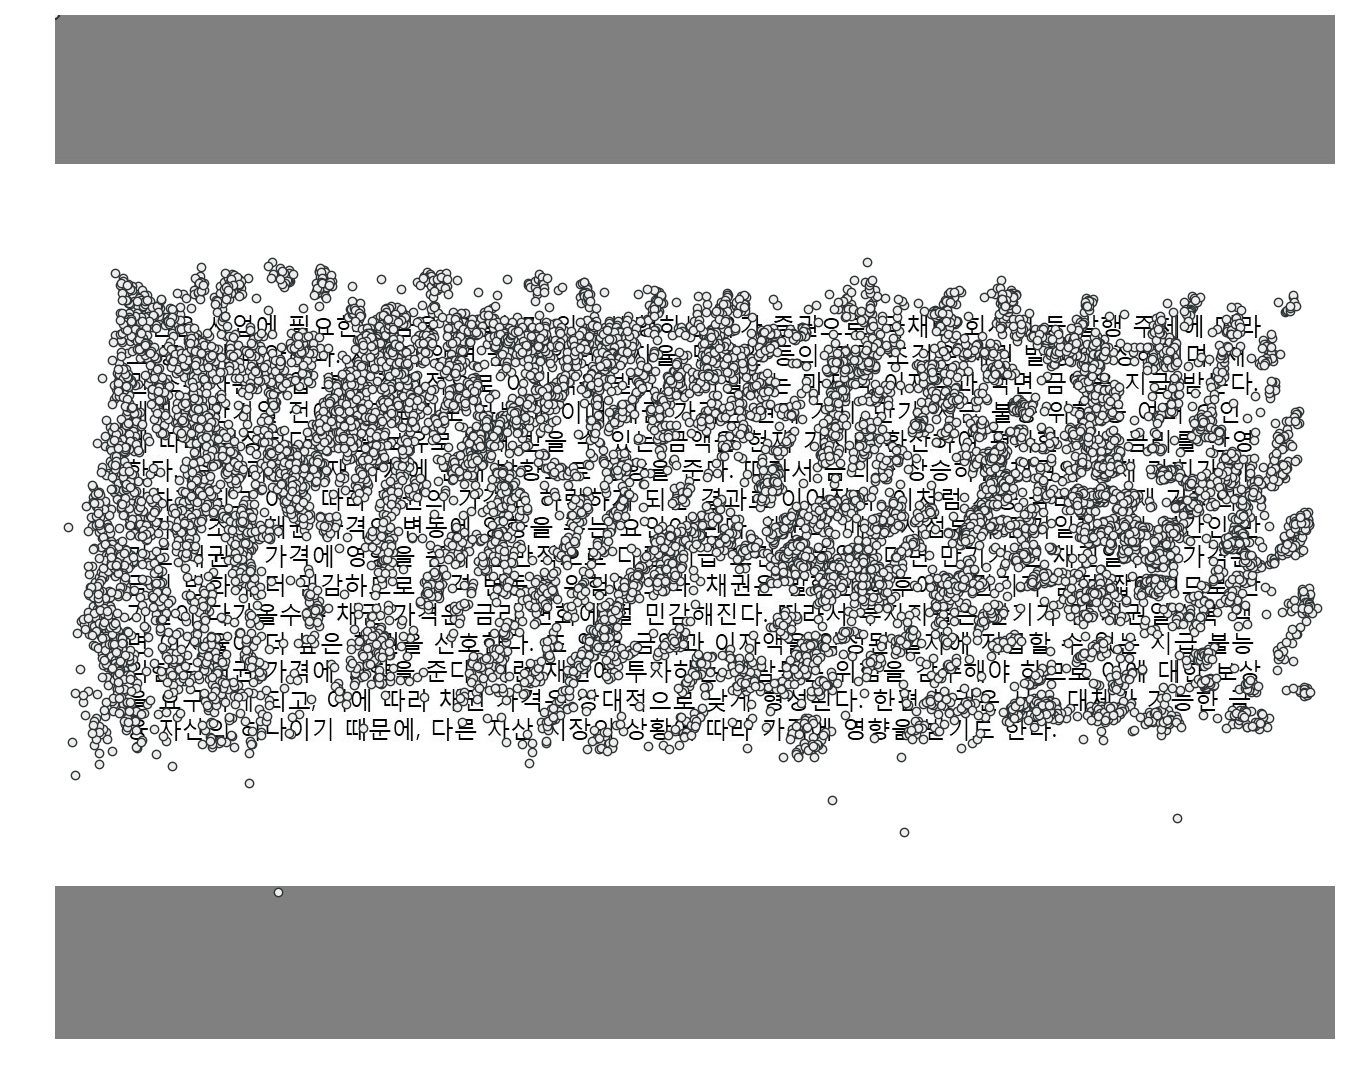

In [118]:
draw_raw(x,y, (1280, 1024), imagefile = './stim_slide001.jpg', savefilename = 'test2.jpg')

### Need to get Variables
- 1 Number of fixations
- 2 Number of saccades
- 3 Number of blinks
- 4 Duration of fixations
- 5 Duration of saccades
- 6 Velocity of saccades
- 7 Acceleration of saccades
- 8 Average pupil size [calculated on non-missing data only of course]

# get values for box-plot
- return format: {1 : [each files value]}, 1 means Number of fixations, caculate above variables
- and I found error in code which can not return correct value on my computer

<img src="error1.jpg">

In [127]:
dirname = "data"
glass = defaultdict(lambda: [])
no_glass = defaultdict(lambda: [])
def result_function(test_dir):
    diction = defaultdict(lambda: [])
    full_path = dirname + "\\" + test_dir
    filelist = os.listdir(full_path)
    for file in filelist:
        f = open(full_path+ "\\" + file, 'r')
    #     while True:
        # read file contents
        print("Now Processing {}".format(file))
        raw = f.readlines()

        #get necessary value
        x,y,t,p = preprocess(raw)
        
        #Blink
        missings, Sblk, Eblk, Ablk = blink_detection(x,y,t, missing=-1.0)

        #Fixation
        Sfix, Efix = fixation_detection(x,y,t, missing=-1.0)
                
#         #Saccades
        Ssac, Esac = saccade_detection(x,y,t, missings, missing= -1.0)
        
        #Make Dictionary
        #Number of fixations
        diction["1"].append(len(Efix))
        
        #Number of saccades
        diction["2"].append(len(Esac))
        
        #Number of blinks
        diction["3"].append(len(Sblk))
        
        #Duration of fixations
        fixDurations = [item[2] for item in Efix]
        diction["4"].append(np.mean(fixDurations))
        
        #Duration of saccades & Velocity of saccades
        sacDurations = [item[6] for item in Esac]
        sacVelocities = [item[7] for item in Esac]
        diction["5"].append(np.mean(sacDurations))
        diction["6"].append(np.mean(sacVelocities))
        
        #Acceleration of saccades
        diction["7"].append(np.mean(Ssac))
        
        #Pupil
        avg_p = get_pupil(p)
        diction["8"].append(np.mean(avg_p))
        #file close
        f.close()
    return diction

In [128]:
glass = result_function("glass")
no_glass = result_function("noglass")

Now Processing participant006_slide001.txt
Now Processing participant007_slide001.txt
Now Processing participant008_slide001.txt
Now Processing participant009_slide001.txt
Now Processing participant010_slide001.txt
Now Processing participant015_slide001.txt
Now Processing participant017_slide001.txt
Now Processing participant020_slide001.txt
Now Processing participant023_slide001.txt
Now Processing participant024_slide001.txt
Now Processing participant025_slide001.txt
Now Processing participant026_slide001.txt
Now Processing participant027_slide001.txt
Now Processing participant028_slide001.txt
Now Processing participant031_slide001.txt
Now Processing participant032_slide001.txt
Now Processing participant001_slide001.txt
Now Processing participant002_slide001.txt
Now Processing participant003_slide001.txt
Now Processing participant004_slide001.txt
Now Processing participant005_slide001.txt
Now Processing participant011_slide001.txt
Now Processing participant012_slide001.txt
Now Process

In [129]:
for i in glass:
    print(i, glass[i], "\n")

1 [432, 343, 92, 463, 199, 24, 454, 8, 422, 361, 466, 501, 50, 327, 516, 487] 

2 [12, 39, 6, 24, 5, 3, 9, 11, 30, 14, 18, 13, 2, 13, 21, 15] 

3 [52, 38, 95, 64, 32, 145, 27, 99, 49, 21, 45, 38, 82, 59, 29, 41] 

4 [118.78422037760417, 102.39053033322705, 94.212877356487766, 119.8439909768156, 89.073813893687188, 70.786519368489579, 116.00165951094438, 72.833709716796875, 104.33454323718898, 107.59406176960699, 141.70640622904372, 123.48288871475799, 74.599536132812503, 103.12309689769687, 157.26479227228683, 117.2353515625] 

5 [480.57561600000002, 433.3905788717949, 450.55104, 444.24817066666668, 514.70274560000007, 612.08405333333337, 461.29026844444445, 478.74950981818171, 454.62396586666665, 517.19855542857135, 442.81710933333329, 562.79634707692298, 446.30476799999997, 506.50509784615383, 514.48317561904753, 554.40059733333339] 

6 [255.55970449165295, 293.34604856935596, 207.11168451286537, 253.78664500096178, 499.82234145001587, 168.90747428242267, 502.01076764382623, 351.8739

In [130]:
for i in no_glass:
    print(i, no_glass[i], "\n")

1 [422, 491, 500, 514, 161, 353, 475, 358, 326, 351, 509, 248, 381, 125, 447, 239, 539, 483] 

2 [10, 28, 16, 29, 5, 11, 11, 12, 11, 6, 30, 6, 13, 6, 17, 7, 16, 17] 

3 [61, 57, 35, 91, 76, 98, 68, 30, 60, 10, 35, 82, 30, 66, 91, 49, 27, 10] 

4 [119.90319014273548, 135.11348760103743, 121.80772314453125, 137.62985906341197, 98.152847195263973, 110.97691176633322, 133.06501336348686, 123.73691460806565, 111.40665215802339, 96.806304670806625, 167.01932835906803, 99.242202266570061, 117.15434365260006, 83.265111328125002, 135.16078926786213, 99.599878031838387, 122.54810702690168, 135.18725535390786] 

5 [504.19921919999996, 476.06087314285713, 489.54278399999998, 485.43685737931031, 421.74105600000001, 441.35545018181824, 446.36937309090899, 553.34920533333343, 456.60416000000004, 462.24733866666662, 444.99474773333327, 565.48164266666663, 378.98362092307696, 588.66850133333332, 453.84869647058827, 464.88795428571427, 446.83942400000001, 390.57796517647063] 

6 [302.07517025568188, 302

# Boxplot


### Number of fixations

The no. of fixations of whom wearing glasses is more various(There are some people who have less no. of fixation than whom not wearing glasses). Medians(red lines) are almost same.

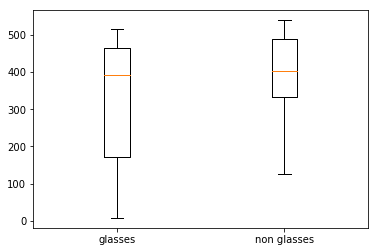

In [131]:
plt.figure()
plt.boxplot((glass['1'], no_glass['1']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Number of saccades

Medians and distributions are almost same. There is no clear difference.

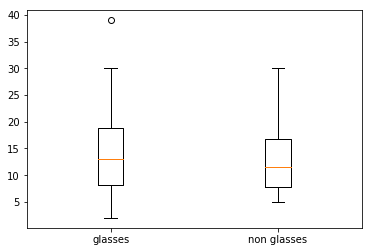

In [63]:
plt.figure()
plt.boxplot((glass['2'], no_glass['2']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Number of blinks

People who do not wearing glasses blink more than the other ones in average. 

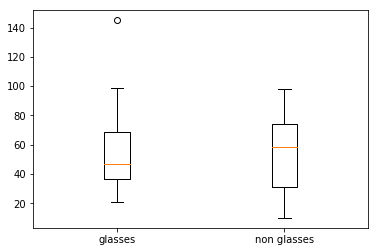

In [64]:
plt.figure()
plt.boxplot((glass['3'], no_glass['3']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Duration of fixations

Duration of whom not wearing glasses is longer than the other ones in average.

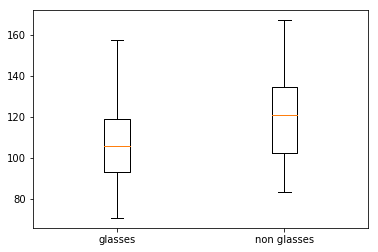

In [65]:
plt.figure()
plt.boxplot((glass['4'], no_glass['4']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Duration of saccades

Duration of whom wearing glasses is a little longer than the other ones in average. 

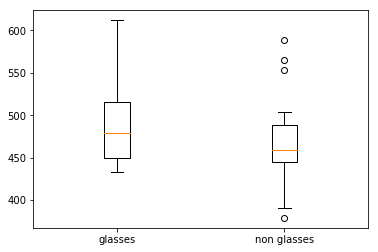

In [66]:
plt.figure()
plt.boxplot((glass['5'], no_glass['5']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Velocity of saccades

People whom wearing glasses move faster than the other ones in average. 

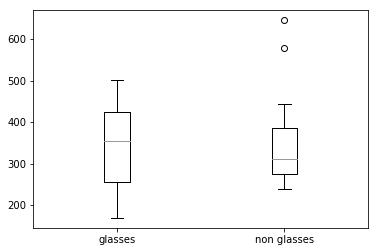

In [67]:
plt.figure()
plt.boxplot((glass['6'], no_glass['6']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Acceleration of saccades

People who wearing glasses accelerate little more than who do not wear(Median is little bit larger). Except some outliers, distributions are almost same. There is no clear difference. 

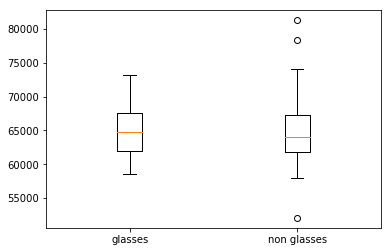

In [58]:
plt.figure()
plt.boxplot((glass['7'], no_glass['7']))
plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

### Average pupil size

People who wearing glasses have bigger pupil than the other ones in average. 

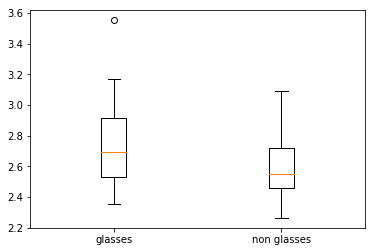

In [134]:
colors = ['yellow', 'blue']
plt.boxplot((glass['8'], no_glass['8']))

plt.xticks([1, 2],['glasses', 'non glasses'])
plt.show()

# Other components versus pupil size

We observe relationship between other components and pupil size. No. of blinks is the most relative component.

### scatter plot and corelation coefficient of each class

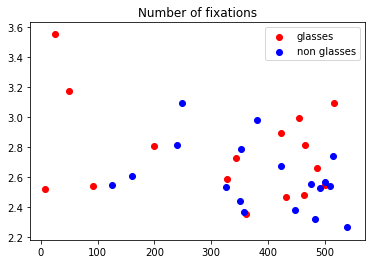

corelation(glasses) : 0.290495909394
corelation(non glasses) : 0.367666202668


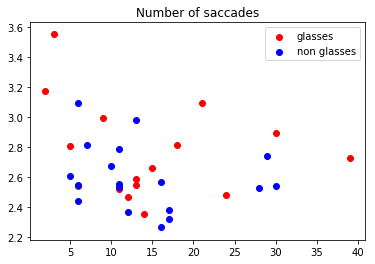

corelation(glasses) : 0.22757841239
corelation(non glasses) : 0.211348784639


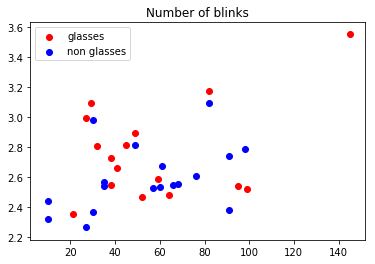

corelation(glasses) : 0.394843952867
corelation(non glasses) : 0.420781538279


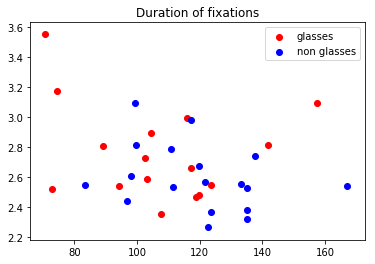

corelation(glasses) : 0.19673422935
corelation(non glasses) : 0.302810742191


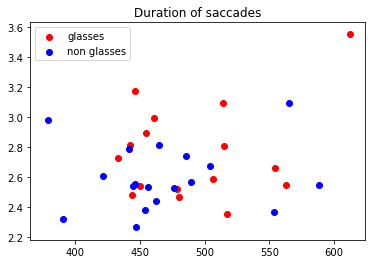

corelation(glasses) : 0.273938355365
corelation(non glasses) : 0.106148859179


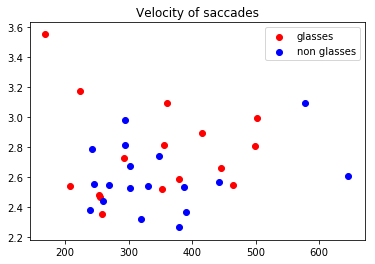

corelation(glasses) : 0.106977361333
corelation(non glasses) : 0.219827080479


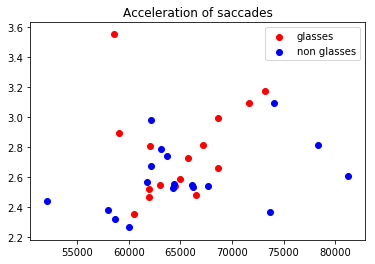

corelation(glasses) : 0.186432741603
corelation(non glasses) : 0.38198055832


In [186]:
naming = ['Number of fixations', 'Number of saccades', 'Number of blinks',
         'Duration of fixations', 'Duration of saccades', 'Velocity of saccades',
         'Acceleration of saccades']
for i in range(0, 7):
    plt.scatter(glass[str(i+1)], glass['8'], color='r', label='glasses')
    plt.scatter(no_glass[str(i+1)], no_glass['8'], color='b', label='non glasses')
    plt.legend()
    plt.title(naming[i])
    plt.show()
    print('corelation(glasses) :', abs(np.corrcoef(glass['8'], glass[str(i+1)])[1][0]))
    print('corelation(non glasses) :', abs(np.corrcoef(no_glass['8'], no_glass[str(i+1)])[1][0]))

### corelation coefficient (whole people)

In [188]:
for i in range(1,8):
    print(naming[i-1], abs(np.corrcoef(glass['8'] + no_glass['8'], glass[str(i)]+no_glass[str(i)])[1][0]))

Number of fixations 0.357955442542
Number of saccades 0.197421616508
Number of blinks 0.399890070989
Duration of fixations 0.301795719014
Duration of saccades 0.240841280498
Velocity of saccades 0.0265209949138
Acceleration of saccades 0.245179970779


# Result

Light could affect the size of pupil. And also, light is relative to the blinking. We think that's why no. of blinks is the most(but not that much) relevant among 7 factors. In fact, there could be auditory or emotional effects. The measuring process would be done while controling auditory stimulation, but it can be hard to measuring or controling emotional effects. 

Reference : "Pupil size variation as an indication of affective processing"